<a href="https://colab.research.google.com/github/carrdata2923/Financial-literacy-predictor/blob/main/Poblaci%C3%B3n_Sint%C3%A9tica_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm

# --- Configuration ---
NUM_STUDENTS = 1000 # Number of synthetic students to generate

# Define categories and probabilities (using midpoint for ranges where appropriate)
EDU_PADRES_CHOICES = ['Primaria_Inferior', 'ESO', 'FP', 'Universitaria']
EDU_PADRES_PROBS = [0.15, 0.25, 0.27, 0.33] # Sums to 1.0

INGRESOS_RANGES = [
    (0, 499), (500, 999), (1000, 1499), (1500, 1999),
    (2000, 2499), (2500, 2999), (3000, 4999), (5000, 100000) # Open ended high income
]
INGRESOS_LABELS = [
    'Hasta_499', '500_999', '1000_1499', '1500_1999',
    '2000_2499', '2500_2999', '3000_4999', '5000_o_mas'
]
INGRESOS_PROBS = [0.032, 0.105, 0.158, 0.146, 0.139, 0.107, 0.214, 0.099] # Sums to 1.0

EXP_LABORAL_CHOICES = ['Con_Experiencia', 'Sin_Experiencia']
# Base probabilities, adjusted by age later
EXP_LABORAL_PROBS_YOUNG = [0.30, 0.70] # 16-19
EXP_LABORAL_PROBS_MID = [0.60, 0.40]   # 20-24
EXP_LABORAL_PROBS_OLD = [0.75, 0.25]   # 25-29

PROD_FINANCIEROS_PROBS = {
    'Cuenta_Bancaria': 0.92,
    'Tarjeta_Debito': 0.82,
    'Tarjeta_Credito': 0.30,
    'Prestamos_Personales': 0.25,
    'Banca_Movil': 0.87,
    'Bizum': 0.80,
    'Inversiones': 0.12,
    'Seguros': 0.22,
    'Planes_Pensiones': 0.07
}

FREC_AHORRO_CHOICES = ['Regularmente', 'Ocasionalmente', 'Nunca']
FREC_AHORRO_PROBS = [0.77, 0.17, 0.06] # Sums to 1.0

CONF_FINANCIERA_CHOICES = ['Alta', 'Moderada', 'Baja']
CONF_FINANCIERA_PROBS = [0.22, 0.50, 0.28] # Sums to 1.0

CONS_INFO_FINAN_CHOICES = ['Frecuente', 'Ocasional', 'Rara_vez_o_Nunca']
CONS_INFO_FINAN_PROBS = [0.27, 0.47, 0.26] # Sums to 1.0

EDU_FINAN_FORMAL_CHOICES = ['Formal', 'Informal', 'Ninguna']
EDU_FINAN_FORMAL_PROBS = [0.27, 0.32, 0.41] # Sums to 1.0

CONOC_MATEMATICO_CHOICES = ['Alto', 'Medio', 'Bajo']
CONOC_MATEMATICO_PROBS = [0.22, 0.50, 0.28] # Sums to 1.0

PLANIF_GASTOS_CHOICES = ['Regularmente', 'Ocasionalmente', 'No_Planifica']
PLANIF_GASTOS_PROBS = [0.37, 0.45, 0.18] # Sums to 1.0

OBJ_FINAN_CHOICES = ['Metas_Claras_Planificadas', 'Metas_No_Planificadas', 'No_Metas']
OBJ_FINAN_PROBS = [0.37, 0.45, 0.18] # Sums to 1.0

# Numerical mapping for income categories
income_map = {
    'Hasta_499': 250, '500_999': 750, '1000_1499': 1250, '1500_1999': 1750,
    '2000_2499': 2250, '2500_2999': 2750, '3000_4999': 4000, '5000_o_mas': 6000
}

# --- Estimated Probabilities for Correctly Answering Each of the 10 Questions ---
QUESTION_PROBS = {
    'P1_Presupuesto': 0.70,      # High: Budget management
    'P2_Inflacion': 0.55,        # Medium: Inflation
    'P3_Interes_Compuesto': 0.50,  # Medium: Compound Interest
    'P4_Diversificacion': 0.30,    # Low: Diversification
    'P5_Ahorro_Inversion': 0.65,   # High: Savings vs. Investment
    'P6_Riesgo_Retorno': 0.40,     # Medium: Risk-Return
    'P7_Prestamo_Variable': 0.45,  # Medium: Variable loan interest
    'P8_Sobreesdeudamiento': 0.75, # High: Over-indebtedness (practical consequence)
    'P9_Coste_Oportunidad': 0.25,  # Low: Opportunity Cost (more theoretical)
    'P10_Seguro_Necessidad': 0.60   # High: Insurance necessity (common sense)
}

# --- Generation Function ---
def generate_synthetic_student_population(num_students=NUM_STUDENTS):
    data = {}

    # 0. Generate Student Age (16-29 years)
    lower_bound_age = 16
    upper_bound_age = 29
    mean_age = 22
    std_dev_age = 3.5
    a_trunc, b_trunc = (lower_bound_age - mean_age) / std_dev_age, (upper_bound_age - mean_age) / std_dev_age
    data['Edad_Estudiante'] = np.round(truncnorm.rvs(a=a_trunc, b=b_trunc, loc=mean_age, scale=std_dev_age, size=num_students)).astype(int)

    # 1. Nivel Educativo de los Padres
    data['Nivel_Educativo_Padres'] = np.random.choice(EDU_PADRES_CHOICES, size=num_students, p=EDU_PADRES_PROBS)

    # 2. Ingreso Mensual del Hogar
    data['Ingreso_Mensual_Hogar_Category'] = np.random.choice(INGRESOS_LABELS, size=num_students, p=INGRESOS_PROBS)
    data['Ingreso_Mensual_Hogar_Num'] = np.array([income_map[label] for label in data['Ingreso_Mensual_Hogar_Category']])

    # 3. Experiencia Laboral Previa (Dependent on student age)
    data['Experiencia_Laboral_Previa'] = np.array([None] * num_students)
    for i in range(num_students):
        age = data['Edad_Estudiante'][i]
        if age <= 19: # 16-19
            data['Experiencia_Laboral_Previa'][i] = np.random.choice(EXP_LABORAL_CHOICES, p=EXP_LABORAL_PROBS_YOUNG)
        elif age <= 24: # 20-24
            data['Experiencia_Laboral_Previa'][i] = np.random.choice(EXP_LABORAL_CHOICES, p=EXP_LABORAL_PROBS_MID)
        else: # 25-29
            data['Experiencia_Laboral_Previa'][i] = np.random.choice(EXP_LABORAL_CHOICES, p=EXP_LABORAL_PROBS_OLD)

    # 4. Educación Financiera Formal (Dependent on income and parental education)
    data['Educacion_Financiera_Formal'] = np.array([None] * num_students)
    for i in range(num_students):
        income_val = data['Ingreso_Mensual_Hogar_Num'][i]
        parent_edu = data['Nivel_Educativo_Padres'][i]

        probs = list(EDU_FINAN_FORMAL_PROBS)
        if income_val >= income_map['3000_4999'] or parent_edu == 'Universitaria':
            probs = [0.35, 0.40, 0.25]
        elif income_val <= income_map['500_999']:
            probs = [0.15, 0.25, 0.60]
        data['Educacion_Financiera_Formal'][i] = np.random.choice(EDU_FINAN_FORMAL_CHOICES, p=probs)

    # 5. Conocimiento Matemático (Dependent on formal financial education and parental education)
    data['Conocimiento_Matematico'] = np.array([None] * num_students)
    for i in range(num_students):
        edu_fin = data['Educacion_Financiera_Formal'][i]
        conoc_mat = data['Conocimiento_Matematico'][i]

        probs = list(CONOC_MATEMATICO_PROBS)
        if edu_fin == 'Formal' or parent_edu == 'Universitaria':
            probs = [0.35, 0.50, 0.15]
        elif edu_fin == 'Ninguna' and parent_edu in ['Primaria_Inferior', 'ESO']:
            probs = [0.10, 0.40, 0.50]
        data['Conocimiento_Matematico'][i] = np.random.choice(CONOC_MATEMATICO_CHOICES, p=probs)

    # 6. Confianza en Decisiones Financieras (Dependent on financial education, math knowledge)
    data['Confianza_Financiera'] = np.array([None] * num_students)
    for i in range(num_students):
        edu_fin = data['Educacion_Financiera_Formal'][i]
        conoc_mat = data['Conocimiento_Matematico'][i]

        probs = list(CONF_FINANCIERA_PROBS)
        if edu_fin == 'Formal' and conoc_mat == 'Alto':
            probs = [0.45, 0.45, 0.10]
        elif edu_fin == 'Ninguna' and conoc_mat == 'Bajo':
            probs = [0.10, 0.40, 0.50]
        data['Confianza_Financiera'][i] = np.random.choice(CONF_FINANCIERA_CHOICES, p=probs)

    # 7. Consumo de Información Financiera (Dependent on confidence, financial education)
    data['Consumo_Info_Financiera'] = np.array([None] * num_students)
    for i in range(num_students):
        conf_fin = data['Confianza_Financiera'][i]
        edu_fin = data['Educacion_Financiera_Formal'][i]

        probs = list(CONS_INFO_FINAN_PROBS)
        if conf_fin == 'Alta' and edu_fin == 'Formal':
            probs = [0.45, 0.45, 0.10]
        elif conf_fin == 'Baja' and edu_fin == 'Ninguna':
            probs = [0.10, 0.35, 0.55]
        data['Consumo_Info_Financiera'][i] = np.random.choice(CONS_INFO_FINAN_CHOICES, p=probs)

    # 8. Objetivos Financieros Personales (Dependent on income, financial education, work experience)
    data['Objetivos_Financieros_Personales'] = np.array([None] * num_students)
    for i in range(num_students):
        income_val = data['Ingreso_Mensual_Hogar_Num'][i]
        edu_fin = data['Educacion_Financiera_Formal'][i]
        exp_laboral = data['Experiencia_Laboral_Previa'][i]

        probs = list(OBJ_FINAN_PROBS)
        if (income_val >= income_map['3000_4999'] and edu_fin == 'Formal') or exp_laboral == 'Con_Experiencia':
            probs = [0.55, 0.35, 0.10]
        elif income_val <= income_map['500_999'] and edu_fin == 'Ninguna':
            probs = [0.15, 0.35, 0.50]
        data['Objetivos_Financieros_Personales'][i] = np.random.choice(OBJ_FINAN_CHOICES, p=probs)

    # 9. Planificación de Gastos (Dependent on income, financial education, work experience, goals)
    data['Planificacion_Gastos'] = np.array([None] * num_students)
    for i in range(num_students):
        income_val = data['Ingreso_Mensual_Hogar_Num'][i]
        edu_fin = data['Educacion_Financiera_Formal'][i]
        exp_laboral = data['Experiencia_Laboral_Previa'][i]
        obj_fin = data['Objetivos_Financieros_Personales'][i]

        probs = list(PLANIF_GASTOS_PROBS)
        if (income_val >= income_map['3000_4999'] and edu_fin == 'Formal' and obj_fin == 'Metas_Claras_Planificadas') or exp_laboral == 'Con_Experiencia':
            probs = [0.60, 0.30, 0.10]
        elif income_val <= income_map['500_999'] and edu_fin == 'Ninguna' and obj_fin == 'No_Metas':
            probs = [0.10, 0.30, 0.60]
        data['Planificacion_Gastos'][i] = np.random.choice(PLANIF_GASTOS_CHOICES, p=probs)

    # 10. Frecuencia de Ahorro (Dependent on income, financial goals, planning)
    data['Frecuencia_Ahorro'] = np.array([None] * num_students)
    for i in range(num_students):
        income_val = data['Ingreso_Mensual_Hogar_Num'][i]
        obj_fin = data['Objetivos_Financieros_Personales'][i]
        plan_gastos = data['Planificacion_Gastos'][i]

        probs = list(FREC_AHORRO_PROBS)
        if (income_val >= income_map['2000_2499'] and obj_fin == 'Metas_Claras_Planificadas' and plan_gastos == 'Regularmente'):
            probs = [0.90, 0.08, 0.02]
        elif income_val <= income_map['500_999'] and obj_fin == 'No_Metas' and plan_gastos == 'No_Planifica':
            probs = [0.10, 0.30, 0.60]
        data['Frecuencia_Ahorro'][i] = np.random.choice(FREC_AHORRO_CHOICES, p=probs)

    # 11. Uso de Productos Financieros
    data['Uso_Productos_Financieros'] = np.array([None] * num_students, dtype=object)
    for i in range(num_students):
        used_products = []
        income_val = data['Ingreso_Mensual_Hogar_Num'][i]
        edu_fin = data['Educacion_Financiera_Formal'][i]
        conoc_mat = data['Conocimiento_Matematico'][i]
        obj_fin = data['Objetivos_Financieros_Personales'][i]

        probs_current = dict(PROD_FINANCIEROS_PROBS)

        # Base / Universal products (high probability)
        if np.random.rand() < probs_current['Cuenta_Bancaria']: used_products.append('Cuenta_Bancaria')
        if np.random.rand() < probs_current['Tarjeta_Debito']: used_products.append('Tarjeta_Debito')
        if np.random.rand() < probs_current['Banca_Movil']: used_products.append('Banca_Movil')
        if np.random.rand() < probs_current['Bizum']: used_products.append('Bizum')

        # Conditional probabilities for more complex products
        # Tarjeta_Credito
        credit_card_prob_adj = probs_current['Tarjeta_Credito']
        if income_val > income_map['2000_2499']: credit_card_prob_adj *= 1.5
        if np.random.rand() < credit_card_prob_adj: used_products.append('Tarjeta_Credito')

        # Prestamos_Personales
        loan_prob_adj = probs_current['Prestamos_Personales']
        if income_val > income_map['3000_4999']: loan_prob_adj *= 1.5
        if np.random.rand() < loan_prob_adj: used_products.append('Prestamos_Personales')

        # Inversiones (stronger dependencies)
        investment_prob_adj = probs_current['Inversiones']
        if income_val >= income_map['3000_4999'] and edu_fin == 'Formal' and obj_fin == 'Metas_Claras_Planificadas' and conoc_mat == 'Alto':
            investment_prob_adj *= 2.0
        elif edu_fin == 'Ninguna' and conoc_mat == 'Bajo':
            investment_prob_adj *= 0.5
        if np.random.rand() < investment_prob_adj: used_products.append('Inversiones')

        # Seguros
        insurance_prob_adj = probs_current['Seguros']
        if income_val > income_map['2000_2499']: insurance_prob_adj *= 1.5
        if np.random.rand() < insurance_prob_adj: used_products.append('Seguros')

        # Planes_Pensiones
        pension_prob_adj = probs_current['Planes_Pensiones']
        if income_val > income_map['3000_4999']: pension_prob_adj *= 2.0
        if np.random.rand() < pension_prob_adj: used_products.append('Planes_Pensiones')

        data['Uso_Productos_Financieros'][i] = used_products

    # --- Simulate Results for the 10 Questions and Calculate Score ---
    question_cols = []
    for q_name in QUESTION_PROBS.keys():
        data[f'Respuesta_{q_name}'] = np.zeros(num_students, dtype=int)
        question_cols.append(f'Respuesta_{q_name}')

    data['Puntuacion_10_Preguntas'] = np.zeros(num_students, dtype=int)
    data['Nivel_Conocimiento_Financiero_10_Preguntas'] = np.array([None] * num_students, dtype=object)

    for i in range(num_students):
        edu_fin = data['Educacion_Financiera_Formal'][i]
        conoc_mat = data['Conocimiento_Matematico'][i]
        conf_fin = data['Confianza_Financiera'][i]
        cons_info = data['Consumo_Info_Financiera'][i]
        income_val = data['Ingreso_Mensual_Hogar_Num'][i]
        parent_edu = data['Nivel_Educativo_Padres'][i]

        correct_answers_count = 0
        for q_name, base_prob in QUESTION_PROBS.items():
            current_prob = base_prob

            # Adjust probability based on student's profile
            if edu_fin == 'Formal':
                current_prob *= 1.2
            if conoc_mat == 'Alto':
                current_prob *= 1.1
            if conf_fin == 'Alta' and cons_info == 'Frecuente':
                current_prob *= 1.05

            # Penalize for lack of education/knowledge
            if edu_fin == 'Ninguna':
                current_prob *= 0.7
            if conoc_mat == 'Bajo':
                current_prob *= 0.8
            if conf_fin == 'Baja' and cons_info == 'Rara_vez_o_Nunca':
                current_prob *= 0.85

            # Income/Parental Education might also play a role for some questions
            if income_val > income_map['3000_4999'] and parent_edu == 'Universitaria':
                    current_prob *= 1.1

            # Ensure probability stays within [0, 1]
            current_prob = max(0.1, min(0.95, current_prob))

            # Simulate answer: 1 for correct, 0 for incorrect
            if np.random.rand() < current_prob:
                data[f'Respuesta_{q_name}'][i] = 1
                correct_answers_count += 1
            else:
                data[f'Respuesta_{q_name}'][i] = 0

        data['Puntuacion_10_Preguntas'][i] = correct_answers_count

        # --- MODIFICATION START ---
        # Assign Nivel_Conocimiento_Financiero_10_Preguntas based on new score thresholds
        if data['Puntuacion_10_Preguntas'][i] < 5:
            data['Nivel_Conocimiento_Financiero_10_Preguntas'][i] = 'Suspenso'
        else: # Score >= 5
            data['Nivel_Conocimiento_Financiero_10_Preguntas'][i] = 'Aprobado'
        # --- MODIFICATION END ---

    df = pd.DataFrame(data)
    return df

# --- Generate the Population ---
synthetic_students_df = generate_synthetic_student_population(NUM_STUDENTS)

# --- Display Initial Results (for validation) ---
print("--- Synthetic Population Sample (First 5 Rows) ---")
print(synthetic_students_df.head())

print("\n--- Distribution of Puntuacion_10_Preguntas (Raw Score) ---")
print(synthetic_students_df['Puntuacion_10_Preguntas'].describe())

print("\n--- NEW Distribution of Nivel_Conocimiento_Financiero_10_Preguntas (Categorized) ---")
print(synthetic_students_df['Nivel_Conocimiento_Financiero_10_Preguntas'].value_counts(normalize=True))

print("\n--- Average Score for Each Question (Synthetic Data) ---")
for q_name in QUESTION_PROBS.keys():
    print(f"Average correct for {q_name}: {synthetic_students_df[f'Respuesta_{q_name}'].mean():.2f}")


print("\n--- Validation of Key Predictor Distributions (Synthetic vs. Expected) ---")

print("\nStudent Age Distribution (Synthetic):")
print(synthetic_students_df['Edad_Estudiante'].value_counts(normalize=True).sort_index())

print("\nParental Education Distribution (Synthetic):")
print(synthetic_students_df['Nivel_Educativo_Padres'].value_counts(normalize=True))

print("\nHogar Income Category Distribution (Synthetic):")
print(synthetic_students_df['Ingreso_Mensual_Hogar_Category'].value_counts(normalize=True).sort_index())

print("\nFormal Financial Education Distribution (Synthetic):")
print(synthetic_students_df['Educacion_Financiera_Formal'].value_counts(normalize=True))

print("\nConfidence Financial Distribution (Synthetic):")
print(synthetic_students_df['Confianza_Financiera'].value_counts(normalize=True))

print("\n--- Example of Dependencies (Synthetic Data) ---")
print("\nAverage Puntuacion_10_Preguntas by Nivel_Conocimiento_Financiero_10_Preguntas:")
print(synthetic_students_df.groupby('Nivel_Conocimiento_Financiero_10_Preguntas')['Puntuacion_10_Preguntas'].mean())

print("\nCross-tab: Nivel_Conocimiento_Financiero_10_Preguntas vs. Formal Financial Education:")
print(pd.crosstab(synthetic_students_df['Nivel_Conocimiento_Financiero_10_Preguntas'], synthetic_students_df['Educacion_Financiera_Formal'], normalize='index'))

print("\nCross-tab: Nivel_Conocimiento_Financiero_10_Preguntas vs. Uso de Inversiones:")
synthetic_students_df['Usa_Inversiones'] = synthetic_students_df['Uso_Productos_Financieros'].apply(lambda x: 1 if 'Inversiones' in x else 0)
print(pd.crosstab(synthetic_students_df['Nivel_Conocimiento_Financiero_10_Preguntas'], synthetic_students_df['Usa_Inversiones'], normalize='index'))
synthetic_students_df = synthetic_students_df.drop(columns=['Usa_Inversiones'])

# --- Save to CSV ---
output_filename = 'synthetic_young_adults_financial_survey_two_levels.csv' # Changed filename
synthetic_students_df.to_csv(output_filename, index=False, encoding='utf-8')

print(f"\nSynthetic data with two levels of financial knowledge saved to {output_filename}")

--- Synthetic Population Sample (First 5 Rows) ---
   Edad_Estudiante Nivel_Educativo_Padres Ingreso_Mensual_Hogar_Category  \
0               28                    ESO                      Hasta_499   
1               21      Primaria_Inferior                      3000_4999   
2               26                    ESO                      3000_4999   
3               22                     FP                      1500_1999   
4               22                     FP                      3000_4999   

   Ingreso_Mensual_Hogar_Num Experiencia_Laboral_Previa  \
0                        250            Con_Experiencia   
1                       4000            Sin_Experiencia   
2                       4000            Con_Experiencia   
3                       1750            Sin_Experiencia   
4                       4000            Con_Experiencia   

  Educacion_Financiera_Formal Conocimiento_Matematico Confianza_Financiera  \
0                      Formal                   Medio      

CSV file 'synthetic_young_adults_financial_survey_two_levels.csv' loaded successfully.
Training set size: 800 samples, labels: Counter({'Aprobado': 429, 'Suspenso': 371})
Test set size: 200 samples, labels: Counter({'Aprobado': 107, 'Suspenso': 93})

Training Random Forest Classifier with class_weight='balanced'...
Random Forest Classifier training complete.

Evaluating the Model on the test set...

--- Classification Report ---
              precision    recall  f1-score   support

    Aprobado       0.75      0.79      0.77       107
    Suspenso       0.74      0.69      0.72        93

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.74      0.74      0.74       200


--- Overall Accuracy Score ---
Accuracy: 0.7450

--- Corrected ROC AUC Calculation ---
Model classes order: ['Aprobado' 'Suspenso']
Corrected ROC AUC Score: 0.8063

--- Feature Importances (Top 10) ---
Educacion_Financiera_Formal_Ninguna  

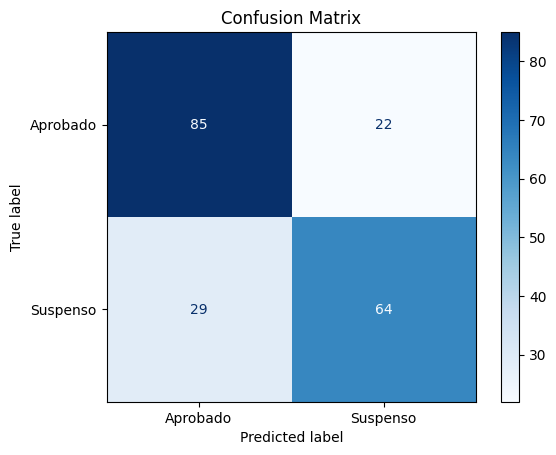

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import ast # To safely evaluate string representation of lists
from collections import Counter
import matplotlib.pyplot as plt # For plotting the confusion matrix

# --- 1. Load the data ---
file_path = 'synthetic_young_adults_financial_survey_two_levels.csv'
try:
    df = pd.read_csv(file_path)
    print(f"CSV file '{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it's uploaded to your environment.")
    exit()
except Exception as e:
    print(f"Error loading the CSV file: {e}")
    exit()

# --- 2. Define Predictors (X) and Target (y) ---
target_variable = 'Nivel_Conocimiento_Financiero_10_Preguntas'
# Excluded 'Edad_Estudiante' as per your previous request
predictor_variables = [
    'Nivel_Educativo_Padres',
    'Ingreso_Mensual_Hogar_Category',
    'Experiencia_Laboral_Previa',
    'Educacion_Financiera_Formal',
    'Conocimiento_Matematico',
    'Confianza_Financiera',
    'Consumo_Info_Financiera',
    'Objetivos_Financieros_Personales',
    'Planificacion_Gastos',
    'Frecuencia_Ahorro',
    'Uso_Productos_Financieros'
]
filtered_predictor_variables = [col for col in predictor_variables if col in df.columns or col == 'Uso_Productos_Financieros']

y = df[target_variable]
X = df[filtered_predictor_variables].copy()

# --- 3. Preprocess Categorical Features ---
# Handle 'Uso_Productos_Financieros' column (stored as string representation of lists)
X['Uso_Productos_Financieros'] = X['Uso_Productos_Financieros'].apply(ast.literal_eval)

mlb = MultiLabelBinarizer()
products_encoded = mlb.fit_transform(X['Uso_Productos_Financieros'])
products_df = pd.DataFrame(products_encoded, columns=[f'Uso_Productos_Financieros_{c}' for c in mlb.classes_], index=X.index)

X = pd.concat([X.drop('Uso_Productos_Financieros', axis=1), products_df], axis=1)

# Perform one-hot encoding for the remaining categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- 4. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]} samples, labels: {Counter(y_train)}")
print(f"Test set size: {X_test.shape[0]} samples, labels: {Counter(y_test)}")


# --- 5. Train a Random Forest Classifier with class_weight ---
print("\nTraining Random Forest Classifier with class_weight='balanced'...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train, y_train)
print("Random Forest Classifier training complete.")

# --- 6. Evaluate the Model ---
print("\nEvaluating the Model on the test set...")
y_pred = rf_model.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Overall Accuracy Score ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Correctly Calculate ROC AUC
print("\n--- Corrected ROC AUC Calculation ---")
print("Model classes order:", rf_model.classes_)
y_test_encoded = y_test.map({'Suspenso': 0, 'Aprobado': 1}) # Map to 0 and 1 for ROC AUC
aprobado_index = list(rf_model.classes_).index('Aprobado') # Get index of 'Aprobado'
y_pred_proba = rf_model.predict_proba(X_test)[:, aprobado_index] # Probabilities for the positive class
try:
    roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
    print(f"Corrected ROC AUC Score: {roc_auc:.4f}")
except ValueError as e:
    print(f"\nError calculating corrected ROC AUC: {e}")

print("\n--- Feature Importances (Top 10) ---")
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print(feature_importances.nlargest(10))

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
# Ensure labels are in the same order as model classes for correct display
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()